In [1]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path
import dill

Using TensorFlow backend.


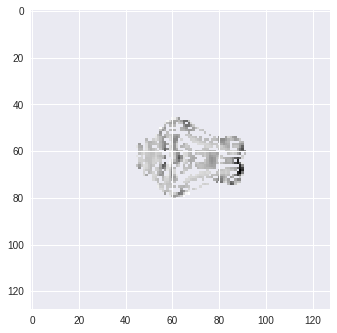

In [2]:
realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
# print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [3]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii



In [4]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

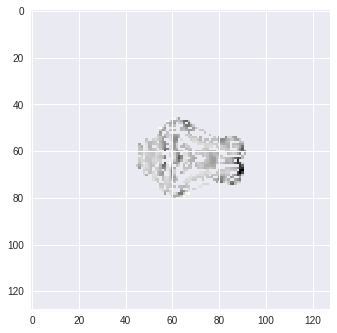

In [5]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [6]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [7]:
## from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import quniform
from keras.callbacks import LearningRateScheduler

import math


def data():
    realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
    mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri)
    
    im = mean_fmri
    all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
    masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

    dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
    dicom_files.sort(key=str)
    time_index = 0
    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

    for f in dicom_files:
        time_file = nib.load(str(f)).get_data()
        fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
        try:
            masked_data[time_index, ...] = fmri_masked_roi
            all_data[time_index, ...] = time_file
            time_index += 1
        except:
            print(f)
    
    
    indices = masked_data[1,:,:,:].nonzero()
    df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
    series_df = pd.Series(index=df_index, dtype=object)

    for i, triple in enumerate(zip(*indices)):
        x, y, z = triple
        trace = all_data[:, x, y, z]

        series_df.loc[triple] = trace
    data_block = np.vstack(series_df.values)[..., np.newaxis]
    
    shuffled_data = np.copy(data_block)
    np.random.shuffle(shuffled_data)

    testing_set = shuffled_data[:700]  #hold back 700 for validation
    training_set = shuffled_data[700:]
    
#     x_train = training_set
#     y_train = training_set
    
#     x_test = testing_set
#     y_test = testing_set
    train_mean = training_set.mean()
    train_std = training_set.std()

    x_train = (training_set - train_mean) / train_std
    y_train = (training_set - train_mean) / train_std
    
    x_test = (testing_set - train_mean) / train_std
    y_test = (testing_set - train_mean) / train_std
    
    return x_train, y_train, x_test, y_test
    
    

def model(x_train, y_train, x_test, y_test):
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    from keras.regularizers import l1
    
    model = keras.models.Sequential()
    
    c1_size = 128
    c1_length = 7
    
    c2_size = 64
    c2_length = 5
    
    c3_size = 32
    c3_length = 3
    
    c4_size = 16
    c4_length = 3
      
    # encoder
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal', input_shape=[300, 1],
                    kernel_regularizer=l1(0.0001))) #Dimensionality 300
    model.add(BatchNormalization())
    model.add(Activation('relu'))

#     model.add(Conv1D(c2_size, c2_length, 
#                      padding='causal', kernel_regularizer=l1(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D())
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal', kernel_regularizer=l1(0.0001))) # Activation map size [150 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal', kernel_regularizer=l1(0.0001))) # Activation map size [75 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    # Activation map size [25 x 1] 
    # Encoding represenation size is [25 x 1 x N (8)] = 200
    # Dimensionality reduction of 300 -> 200
    
    # decoder
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal', kernel_regularizer=l1(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal', kernel_regularizer=l1(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
#     model.add(Conv1D(c2_size, c2_length, 
#                      padding='causal', kernel_regularizer=l1(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(UpSampling1D())
    
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal', kernel_regularizer=l1(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal', kernel_regularizer=l1(0.0001)))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    # learning rate schedule
#     def step_decay(epoch):
#         initial_lrate = 0.01
#         drop = 0.5
#         epochs_drop = 10.0
#         lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
#         return lrate
    kicker = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, 
                                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
#     lrate = LearningRateScheduler(step_decay)
    callbacks_list = [
        keras.callbacks.TerminateOnNaN(), 
                      kicker,
#                      keras.callbacks.TensorBoard(log_dir='./e11_logs',
#                                                 histogram_freq=1,
#                                                 write_grads=False,
#                                                 embeddings_freq=0,
#                                                 )
    ]
    
#     opt = keras.optimizers.SGD(0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    opt = keras.optimizers.Nadam()
    model.compile(optimizer=opt, loss='logcosh')
    model.fit(x_train, y_train, epochs=20, batch_size=64, 
              callbacks=callbacks_list, validation_data=(x_test, x_test))
    
    loss = model.evaluate(x_test, x_test)
    
    if np.isnan(loss):
        loss = float('inf')
        
    
    return {'loss': loss, 'model': model}

x_train, y_train, x_test, y_test = data()
out = model(x_train, y_train, x_test, y_test)
print(out)


../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii
Train on 6455 samples, validate on 700 samples
Epoch 1/20
6455/6455 [==============================] - 3s - loss: 0.0757 - val_loss: 0.3604
Epoch 2/20
6455/6455 [==============================] - 1s - loss: 0.0541 - val_loss: 0.3434
Epoch 3/20
6455/6455 [==============================] - 1s - loss: 0.0477 - val_loss: 0.2956
Epoch 4/20
6455/6455 [==============================] - 1s - loss: 0.0489 - val_loss: 0.0602
Epoch 5/20
6455/6455 [==============================] - 1s - loss: 0.0455 - val_loss: 0.0984
Epoch 6/20
6455/6455 [==============================] - 1s - loss: 0.0413 - val_loss: 0.0968
Epoch 7/20
6455/6455 [==============================] - 1s - loss: 0.0383 - val_loss: 0.1586
Epoch 8/20
6455/6455 [==============================] - 1s - loss: 0.0374 - val_loss: 0.1586
Epoch 9/20
6455/6455 [==============================] - 1s - loss: 0.0308 - val_loss: 0.0850
Epoch 10/20
6455/6455 [==============================] - 

In [8]:
{'batch_size': 32,
'c1_filters': 56,
'c1_length': 8,
'c2_filters': 34,
'c2_length': 6,
'c3_filters': 20,
'c3_length': 12,
'c4_filters': 1,
'c4_length': 6,
'optimizer': 'adam'}

{'batch_size': 32,
 'c1_filters': 56,
 'c1_length': 8,
 'c2_filters': 34,
 'c2_length': 6,
 'c3_filters': 20,
 'c3_length': 12,
 'c4_filters': 1,
 'c4_length': 6,
 'optimizer': 'adam'}

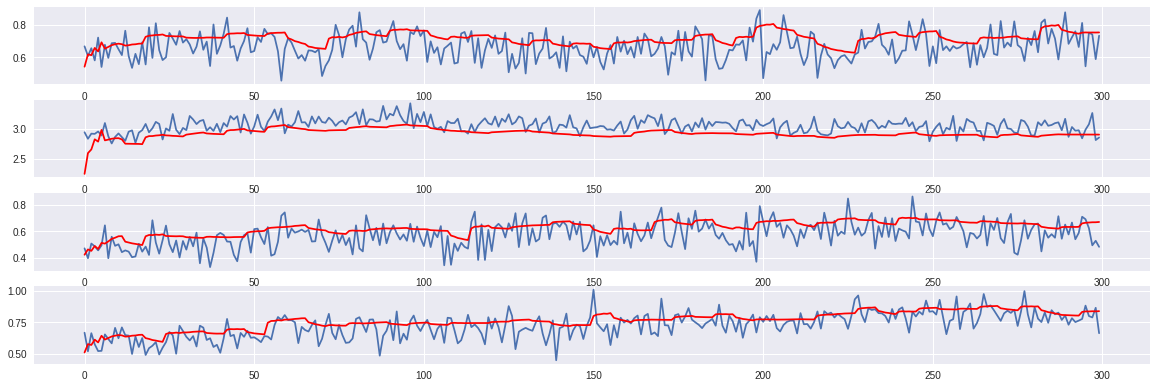

In [9]:
from keras import backend as K
from keras.models import load_model

m = out['model']

sample_1 = x_train[np.newaxis, 0]
output_1 = m.predict(sample_1)

sample_2 = x_train[np.newaxis, 22]
output_2 = m.predict(sample_2)

sample_3 = x_train[np.newaxis, 66]
output_3 = m.predict(sample_3)

sample_4 = x_train[np.newaxis, 6000]
output_4 = m.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')